In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 1

In [2]:
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

import numpy as np
import cv2

from sklearn.model_selection import KFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC, SVR

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram



from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

from src.utils.feats import load_gei
from src.utils.plot_config import set_plot_config
from src.utils.results import df_results
from src.utils.bayes_optim import bayes_search

# Plots

In [3]:
set_plot_config()

In [4]:
# load
datapath = "../data/feats/database24_gei_480x640.pkl"

dim = (32, 24)
crop_person = True

X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     

In [5]:
def plot2d(X_trans, y):
    plt.figure(figsize=(10,8))
    plt.scatter(X_trans[:,0], X_trans[:,1], c=y, cmap=plt.cm.jet)
    
    plt.xlabel('$x_1$')    
    plt.ylabel('$x_2$')
    
    plt.show()
    
    
def plot3d(X_trans, y):
    
    
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)

    ax.scatter(X_trans[:, 0], X_trans[:, 1], X_trans[:, 2], c=y,
               cmap=plt.cm.jet, edgecolor='k', s=40)
    
    ax.set_xlabel("$x_1$")
    ax.w_xaxis.set_ticklabels([])
    
    ax.set_ylabel("$x_2$")
    ax.w_yaxis.set_ticklabels([])
    
    ax.set_zlabel("$x_3$")
    ax.w_zaxis.set_ticklabels([])
    
    
    
    
#     ax = plt.figure(figsize=(10,8)).gca(projection='3d')    
    
#     ax.scatter(xs=X_trans[:,0], ys=X_trans[:,1], zs=X_trans[:,2], c=y, cmap=plt.cm.jet)
#     ax.set_xlabel('$x_1$')
#     ax.set_ylabel('$x_2$')
#     ax.set_zlabel('$x_3$')
    
    plt.show()
    
    

## PCA

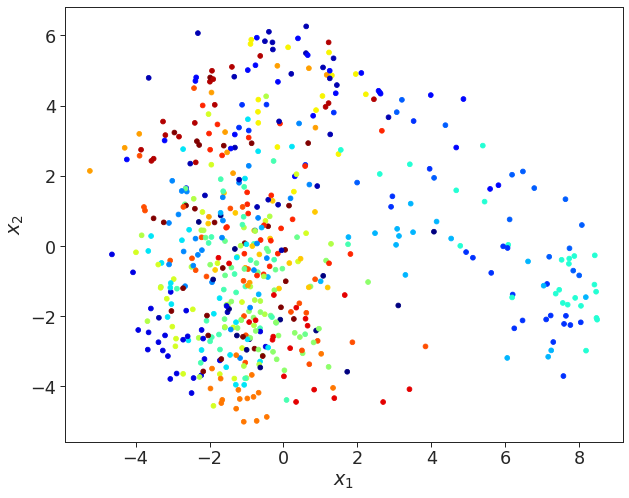

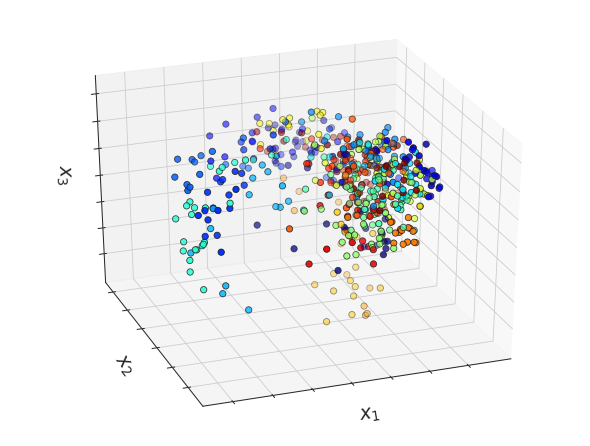

In [6]:
plot2d(PCA(n_components=2).fit_transform(X), y)
plot3d(PCA(n_components=3).fit_transform(X), y)

## LDA

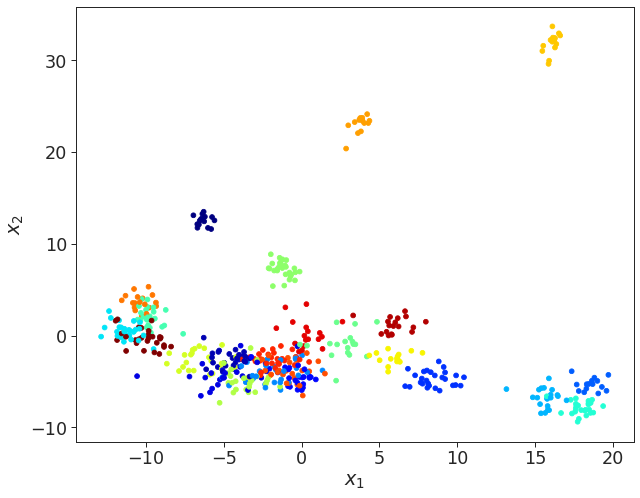

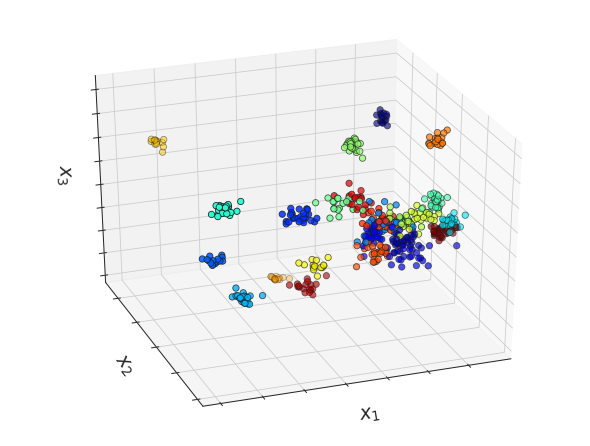

In [7]:
plot2d(LDA(n_components=2).fit_transform(X, y),y)
plot3d(LDA(n_components=3).fit_transform(X, y),y)

## T-SNE

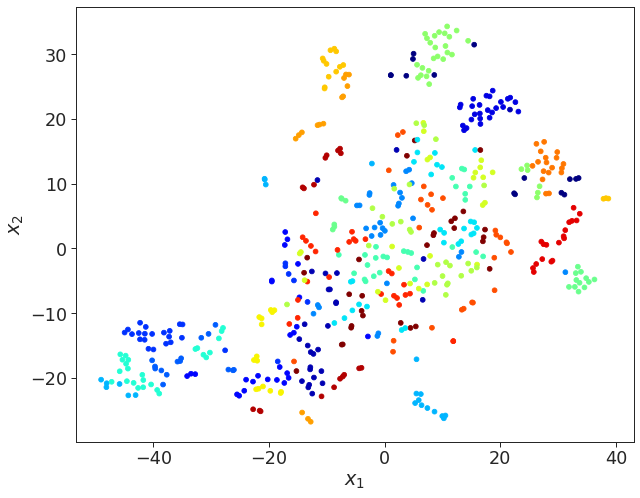

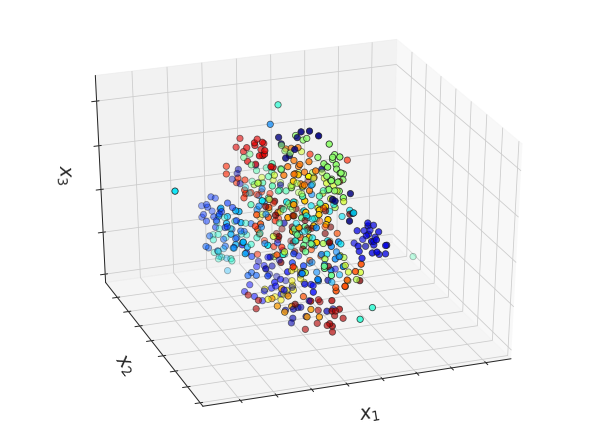

In [8]:
plot2d(TSNE(n_components=2).fit_transform(X),y)     
plot3d(TSNE(n_components=3).fit_transform(X),y)

# Training Models

In [9]:
# Kfold
n_splits = 3
cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)  

In [10]:
dim = (64, 48)
crop_person = True

X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

In [11]:
# pipeline class is used as estimator to enable
# search over different model types

base_pipe = Pipeline([   
    ('reduction', PCA()),
    ('model', SVC())
])

## PCA

In [12]:
# single categorical value of 'model' parameter is
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
# linsvc_search = {
#     'model': [LinearSVC(max_iter=1000)],
#     'model__C': (1e-6, 1e+6, 'log-uniform'),
# }

# explicit dimension classes can be specified like this

knn_PCA = {
    'reduction': Categorical([PCA(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_PCA = {
    'reduction': Categorical([PCA(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_PCA = {
    'reduction': Categorical([PCA(random_state=0),]),
    'reduction__n_components': Integer(60, 80),
#     'model': Categorical([SVC(C=0.285873, degree=5.0, gamma=0.002535, kernel='linear', )]),
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+2, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt_PCA = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations)
    [(knn_PCA, 64), (rf_PCA, 64), (svc_PCA, 64),],
    cv=cv
).fit(X, y)

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

In [13]:
df_PCA = df_results(opt_PCA)
df_PCA

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
153,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,2404.712361,8.0,100.000000,linear,0.879342,0.013699,1
158,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",68,NaN,20708.111598,1.0,100.000000,linear,0.875686,0.013096,2
191,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",80,NaN,34.125333,1.0,100.000000,poly,0.873857,0.008075,3
163,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",80,NaN,45.870601,1.0,0.000001,linear,0.873857,0.008075,3
169,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",80,NaN,37256.437884,1.0,100.000000,poly,0.873857,0.008075,3
...,...,...,...,...,...,...,...,...,...,...,...,...
132,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",63,NaN,0.086279,2.0,0.000005,poly,0.038391,0.009038,185
133,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,0.002992,1.0,0.000275,poly,0.038391,0.009038,185
135,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,19481.895316,2.0,4.569546,rbf,0.038391,0.009038,185
150,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",60,NaN,0.000001,6.0,100.000000,linear,0.038391,0.009038,185


In [14]:
# 5 best knn models
df_PCA[df_PCA['model__n_neighbors']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
54,KNeighborsClassifier(),1.0,PCA(random_state=0),42,NaN,NaN,NaN,NaN,NaN,0.758684,0.011226,54
45,KNeighborsClassifier(),1.0,PCA(random_state=0),48,NaN,NaN,NaN,NaN,NaN,0.758684,0.008418,54
39,KNeighborsClassifier(),1.0,PCA(random_state=0),25,NaN,NaN,NaN,NaN,NaN,0.758684,0.000623,54
37,KNeighborsClassifier(),1.0,PCA(random_state=0),20,NaN,NaN,NaN,NaN,NaN,0.756856,0.004890,57
23,KNeighborsClassifier(),1.0,PCA(random_state=0),67,NaN,NaN,NaN,NaN,NaN,0.755027,0.008701,60


In [15]:
# 5 best RF models
df_PCA[df_PCA['model__n_estimators']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
99,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),40,400.0,NaN,NaN,NaN,NaN,0.762340,0.009911,50
98,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),40,400.0,NaN,NaN,NaN,NaN,0.762340,0.009911,50
82,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),20,150.0,NaN,NaN,NaN,NaN,0.760512,0.017210,52
102,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),40,333.0,NaN,NaN,NaN,NaN,0.760512,0.007423,52
108,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),61,400.0,NaN,NaN,NaN,NaN,0.756856,0.013762,57


In [16]:
# 5 best SVC models
df_PCA[df_PCA['model__C']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
153,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,2404.712361,8.0,100.000000,linear,0.879342,0.013699,1
158,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",68,NaN,20708.111598,1.0,100.000000,linear,0.875686,0.013096,2
191,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",80,NaN,34.125333,1.0,100.000000,poly,0.873857,0.008075,3
163,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",80,NaN,45.870601,1.0,0.000001,linear,0.873857,0.008075,3
169,"SVC(C=2404.7123613541926, degree=8, gamma=100....",NaN,"PCA(n_components=70, random_state=0)",80,NaN,37256.437884,1.0,100.000000,poly,0.873857,0.008075,3


## LDA

In [17]:
LDA_params = {
    'reduction': Categorical([LDA(),]),
#     n_components cannot be larger than min(n_features, n_classes - 1).
    'reduction__n_components': Integer(15,  min(X.shape[1], np.unique(y).shape[0] - 1)),
}

In [18]:
knn_LDA = {
    **LDA_params,
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_LDA = {
    **LDA_params,
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_LDA = {
    **LDA_params,
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt_LDA = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations),
    [(knn_LDA, 64), (rf_LDA, 64), (svc_LDA, 64),],
    cv=cv,
).fit(X, y)



/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

In [19]:
df_LDA = df_results(opt_LDA[])
df_LDA

SyntaxError: invalid syntax (<ipython-input-19-4c84e224f873>, line 1)

In [ ]:
# 5 best knn models
df_LDA[df_LDA['model__n_neighbors']>0].head(5)

In [ ]:
# 5 best RF models
df_LDA[df_LDA['model__n_estimators']>0].head(5)

In [ ]:
# 5 best SVC models
df_LDA[df_LDA['model__C']>0].head(5)